# Measurement

In [1]:
import imageio as iio
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import numpy as np

## Segmentation and labeling

Learning how to label objects:

We use segmentation to split images into parts.
We will focus on how to analyse the resulting objects. We're gonna use the Sunnybrook Cardiac database to try to measure the proportion of blood pumped out of the heart's left ventricle (Also known as ejection fraction). Abnormal ejection fractions can indicate health problems. 

First we're gonna have to segment the left ventricle from the rest of the image. In our case this corresponds to high intensities, so we can use a filter to smooth the image and reduce noise, then mask it. Once we have properly isolated our objective we have to delete the rest of the active pixels. We can do this using python's labeling function.

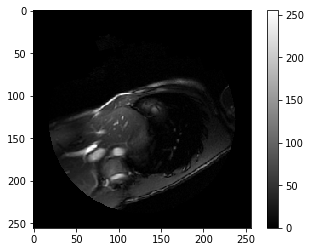

In [9]:
im = iio.imread('sunnybrook-cardiac-mr/SCD2001_000/SCD2001_MR_201.dcm')

plt.imshow(im, cmap='gray')
plt.colorbar()

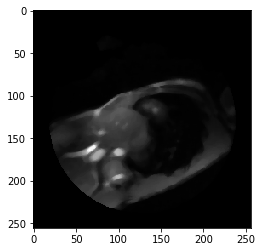

In [77]:
filt = ndi.median_filter(im, size=6)
plt.imshow(filt, cmap='gray')

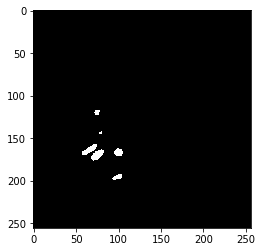

In [79]:
mask = filt > 120
plt.imshow(mask, cmap='gray')

In [80]:
#this function treats 0 values as background and then looks for all objects separated by background
#It then returns an array in which the objects have been indexes and the number of objects
labels, nlabels = ndi.label(mask)
nlabels

6

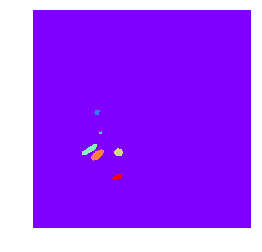

In [81]:
plt.imshow(labels, cmap='rainbow')
plt.axis('off')
plt.show()

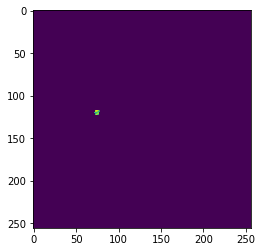

In [82]:
#we can now select a single label within an image
lab1 = np.where(labels == 1, im, 0)
plt.imshow(lab1)

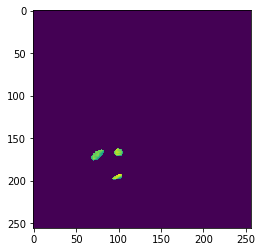

In [83]:
##### Or selecting many labels
lable12 = np.where(labels>3, im, 9)
plt.imshow(lable12)

In [84]:
labels.shape

(256, 256)

A bounding box is the range of pixels that completely encloses an object. We'll use bounding boxes to extract objects from the larger image.
We'll create this boxes with the ndi.find_objects() function that returns a list of bounding box coordinates

In [85]:
boxes = ndi.find_objects(labels)
boxes[0]

(slice(117, 123, None), slice(72, 79, None))

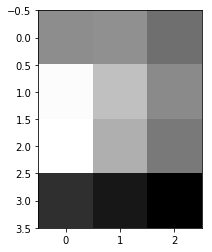

In [87]:
object_1 = im[boxes[1]]
plt.imshow(object_1, cmap='gray')

In [ ]:
# Create a `labels` overlay
overlay = np.where(labels>0, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
format_and_render_plot()

Robust image segmentation is an entire research domain, but the simple principle is to leverage intensity and location information to differentiate objects of interest from the background. Once labeled, the objects can be manipulated easily.

In [ ]:
#To find in which label is the object we want
# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels[128, 128] #this returns the label number we want
lv_mask = np.where(labels== lv_val, 1, np.nan)

# Overlay selected label
plt.imshow(lv_mask, cmap='rainbow')
plt.show()

In [ ]:
# Create left ventricle mask
labels, nlabels = ndi.label(mask)
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)

# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

# Crop to the left ventricle (index 0)
im_lv = im[bboxes[0]]

# Plot the cropped image
plt.imshow(im_lv)
format_and_render_plot()

### Measuring intensity
Now that our object of interest has been extracted we can start analysing its properties. 

scipy.ndimage.measurements has tons of functions that will help us analys. These functions work over all dimesions. Combined with labels we can apply them to each object independetly with a single call.

For custom functions: ndi.labeled_compehension()

Reading DICOM (examining files): 1/21 files (4.8%21/21 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 21/21  (100.0%)


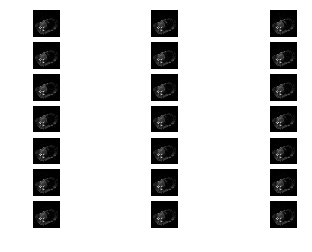

In [97]:
#we create the volume image we'll analyse
vol = iio.volread('sunnybrook-cardiac-mr/SCD2001_000')
#plotting multiple images at once with plt.subplots
fig, axes = plt.subplots(nrows=7, ncols=3)
axes = axes.flatten() #because axes is 2D array
i = 0
for a in axes:
    a.imshow(vol[i], cmap='gray')
    a.axis('off')
    i += 1

In [96]:
axes.shape

(7, 3)

In [91]:
#no idea if label will work on volumes
labels, nlabels = ndi.label(vol)
nlabels

31

In [98]:
#To get mean intensity of all pixels including background
ndi.mean(vol)

13.214210146949405

In [100]:
#providing an array or a mask
#mean over all labeled parts
ndi.mean(vol, labels)

27.634262825918817

In [101]:
#mean at the indexed label
ndi.mean(vol, labels, index = 1)

4.259263456090651

In [102]:
#mean at the indexed labels
ndi.mean(vol, labels, index = [1,2,3])

array([ 4.25926346, 27.95379464,  1.        ])

In [103]:
# we can also use this technique for histograms
#and get distributions for each of the selected labels
obj_hists = ndi.histogram(vol, 0, 255, 256, labels, index=[1,2])

Plotting the object histograms is a good way to evaluate segmentation. Histograms containing multiple tissue types will have several peaks = not a good segmentation. 

Histogram = normal dist. then segmentation might be doing a good job. This is because the physical properties than influence intensity should be relatively uniform throughout a tissue.  

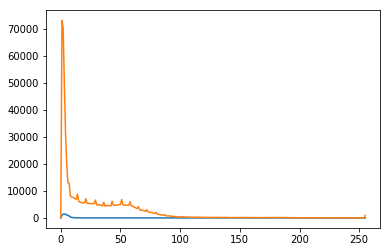

In [104]:
plt.plot(obj_hists[0])
plt.plot(obj_hists[1])
plt.show()

In [ ]:
# Variance for all pixels
var_all = ndi.variance(vol)
print('All pixels:', var_all)

# Variance for labeled pixels
var_labels = ndi.variance(vol, labels)
print('Labeled pixels:', var_labels)

# Variance for each object
var_objects = ndi.variance(vol, labels, index=[1,2])
print('Left ventricle:', var_objects[0])
print('Other tissue:', var_objects[1])

### Separate histograms
A poor tissue segmentation includes multiple tissue types, leading to a wide distribution of intensity values and more variance.

On the other hand, a perfectly segmented left ventricle would contain only blood-related pixels, so the histogram of the segmented values should be roughly bell-shaped.

For this exercise, compare the intensity distributions within vol for the listed sets of pixels. Use ndi.histogram, which also accepts labels and index arguments.

In [ ]:
# Create histograms for selected pixels
hist1 = ndi.histogram(vol, min=0, max=255, bins=256)
hist2 = ndi.histogram(vol, 0, 255, 256, labels=labels)
hist3 = ndi.histogram(vol, 0, 255, 256, labels=labels, index=1)

# Plot the histogram density
#notice that we have to rescale them
plt.plot(hist1 / hist1.sum(), label='All pixels')
plt.plot(hist2/hist2.sum(), label='All labeled pixels')
plt.plot(hist3/hist3.sum(), label='Left ventricle')
format_and_render_plot()

## Measuring Morphology (shape and size)
How big a tumour is? Has it grown?

Spacial extent is the product of:
- Space occupied by each element
- Number of array elements

In [105]:
#to calculate the volume per voxel
#in this case cubic mm
d0, d1, d2 = vol.meta['sampling']
dvoxel = d0*d1*d2

In [107]:
#to count the number of voxels in a label
nvoxels = ndi.sum(1, label, index=1)

In [109]:
#total volume of object
volume = nvoxels * dvoxel

Another useful measurement is the distance from each voxel to the nearest background value (distance transformation). This info can help identify the most embeded points in an object or mask out edge areas.

In [116]:
#create a left ventricle mask
mask = np.where(labels ==1, 1, 0)

#in terms of voxels
#euclidean distance
d = ndi.distance_transform_edt(mask)

#this returns an array in which all non-zero voxels has been replaaced by its distance to the nearest background voxel
#d.max is the distance from the most embeded point to the edge
d.max()

4.47213595499958

In [117]:
#If we have access to sampling rates we can use them to get actual physical distances
d = ndi.distance_transform_edt(mask, sampling = vol.meta['sampling'])
d.max()

3.0571253060219825

Complementary measure: Center of mass (COM)

Mass = intensity in this case

In [119]:
#COM function accepts labels and indices
com = ndi.center_of_mass(vol, labels, index=1)
com

(9.898691071618602, 38.03211131212089, 86.80504416303076)

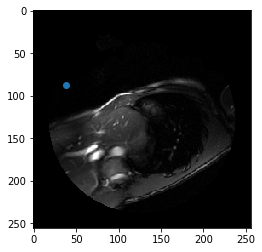

In [122]:

#not working
plt.imshow(vol[10], cmap='gray') #approx in which plane
plt.scatter(com[2], com[1])
plt.show()

### Calculate distance
A distance transformation calculates the distance from each pixel to a given point, usually the nearest background pixel. This allows you to determine which points in the object are more interior and which are closer to edges.

For this exercise, use the Euclidian distance transform on the left ventricle object in labels.

In [ ]:
# Calculate left ventricle distances
lv = np.where(labels==1, 1, 0)
dists = ndi.distance_transform_edt(lv, sampling = vol.meta['sampling'])

# Report on distances
print('Max distance (mm):', ndi.maximum(dists))
print('Max location:',ndi.maximum_position(dists) )

# Plot overlay of distances
overlay = np.where(dists[5] > 0, dists[5], np.nan) 
plt.imshow(overlay, cmap='hot')
format_and_render_plot()

### Pinpoint center of mass
The distance transformation reveals the most embedded portions of an object. On the other hand, ndi.center_of_mass() returns the coordinates for the center of an object.

The "mass" corresponds to intensity values, with higher values pulling the center closer to it.

For this exercise, calculate the center of mass for the two labeled areas. Then, plot them on top of the image.

In [ ]:
# Extract centers of mass for objects 1 and 2
coms = ndi.center_of_mass(vol, labels, index=[1,2])
print('Label 1 center:', coms[0])
print('Label 2 center:', coms[1])

# Add marks to plot
for c0, c1, c2 in coms:
    plt.scatter(c2, c1, s=100, marker='o')
plt.show()

### Measuring in time
Now let's find the ejection fraction

$Ejection Fraction = \frac{LV_{max}-LV_{min}}{LV_{max}}$

We could do the following:
- segment left ventricle
- for each 3D volume in the time series, calculate volume
- select min and max
- calculate ejection frac

Let's assume we have access to the segmented LV and to each 3D vol. We have 4D data this time

In [123]:
#stored in (t, z, y, x) format
vol_ts.shape
labels.shape

#calc voxel volume in mm^3
d0, d1, d2, d3 = vol_ts.meta['sampling']
dvoxel = d1*d2*d3

#empty list to save volumes
ts = np.zeros(20)

for t in range(20):
    nvoxels = ndi.sum(1, labels[t], index=1)
    ts[t] = nvoxels*dvoxel

plt.plot(ts)
plt.show()

#now we can easily select min and max
min_vol = ts.min()
max_vol = ts.max()

ejec_frac = (max_vol - min_vol)/ max_vol

NameError: name 'vol_ts' is not defined

Get the index of the minimum and maximum volume images using np.argmin() and np.argmax().
Plot the extreme volumes together. Display the images along the fifth plane, e.g. (vol_ts[t, 4]).

In [ ]:
# Get index of max and min volumes
tmax = np.argmax(ts)
tmin = np.argmin(ts)

# Plot the largest and smallest volumes
fig, axes = plt.subplots(2,1)
axes[0].imshow(vol_ts[tmax,4], vmax=160)
axes[1].imshow(vol_ts[tmin,4], vmax=160)
format_and_render_plots()